In [25]:
import torch
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

from torchlight import import_class

In [27]:
data_path = r'D:\HaAnh\AimCLR-v2-main\data_cobot_clr_new\xsub\val_position.npy'
label_path = r'D:\HaAnh\AimCLR-v2-main\data_cobot_clr_new\xsub\val_label.pkl'

data_val = np.load(data_path, mmap_mode='r')
with open(label_path, 'rb') as f:
    sample_names, labels_val = pickle.load(f)
labels_val = np.array(labels_val)

In [28]:
import sys
sys.path.append(r'D:\HaAnh\AimCLR-v2-main\net')

In [29]:
model_path = r'D:\HaAnh\AimCLR-v2-main\trial10_proj512_512_128_2BN_Newdata\linear\best_model.pt'

model_class = import_class('net.aimclr_v2_3views_2.AimCLR_v2_3views')
model_args = {
    'base_encoder': 'net.ddnet.DDNet_Original',
    'pretrain': False,
    'class_num': 19,
    'frame_l': 60,
    'joint_d': 3,
    'joint_n': 48,
    'filters': 16,
    'last_feture_dim': 512,
    'feat_d': 1128

}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_class(**model_args)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model = model.to(device)
model.eval()

AimCLR_v2_3views(
  (encoder_q): DDNet_Original(
    (jcd_conv1): Sequential(
      (0): c1D(
        (conv1): Conv1d(1128, 32, kernel_size=(1,), stride=(1,), bias=False)
        (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): spatialDropout1D(
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (jcd_conv2): Sequential(
      (0): c1D(
        (conv1): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): spatialDropout1D(
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (jcd_conv3): c1D(
      (conv1): Conv1d(16, 16, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (jcd_pool): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [30]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.encoder_q = base_model.encoder_q
        self.encoder_q_motion = base_model.encoder_q_motion
        self.encoder_q_bone = base_model.encoder_q_bone
        # Bỏ linear của encoder
        self.encoder_q.linear0 = torch.nn.Identity()
        self.encoder_q.linear1 = torch.nn.Identity()
        self.encoder_q.linear2 = torch.nn.Identity()
        self.encoder_q.linear3 = torch.nn.Identity()

        self.encoder_q_motion.linear0 = torch.nn.Identity()
        self.encoder_q_motion.linear1 = torch.nn.Identity()
        self.encoder_q_motion.linear2 = torch.nn.Identity()
        self.encoder_q_motion.linear3 = torch.nn.Identity()


        self.encoder_q_bone.linear0 = torch.nn.Identity()
        self.encoder_q_bone.linear1 = torch.nn.Identity()
        self.encoder_q_bone.linear2 = torch.nn.Identity()
        self.encoder_q_bone.linear3 = torch.nn.Identity()

    def forward(self, im_q_extreme, im_q, stream):
        # gọi AimCLR.forward() đúng signature
        feat = self.base_model(im_q_extreme=None, im_q=im_q, stream='all')
        return feat


# Khởi tạo
feat_model = FeatureExtractor(model).to(device)
feat_model.eval()


FeatureExtractor(
  (base_model): AimCLR_v2_3views(
    (encoder_q): DDNet_Original(
      (jcd_conv1): Sequential(
        (0): c1D(
          (conv1): Conv1d(1128, 32, kernel_size=(1,), stride=(1,), bias=False)
          (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): spatialDropout1D(
          (dropout): Dropout2d(p=0.1, inplace=False)
        )
      )
      (jcd_conv2): Sequential(
        (0): c1D(
          (conv1): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): spatialDropout1D(
          (dropout): Dropout2d(p=0.1, inplace=False)
        )
      )
      (jcd_conv3): c1D(
        (conv1): Conv1d(16, 16, kernel_size=(1,), stride=(1,), bias=False)
        (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (jcd_pool): Sequential(


In [31]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(torch.from_numpy(data_val).float())
loader = DataLoader(dataset, batch_size=32, shuffle=False)

features = []
with torch.no_grad():
    for (batch,) in loader:
        batch = batch.to(device)
        feat = model(None, batch, stream='all')
        features.append(feat.cpu())

features = torch.cat(features).numpy()
print(features.shape)


C:\Users\Nguyen Ha Anh\AppData\Roaming\Python\Python312\site-packages\torch\nn\functional.py:1542: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


(1330, 128)


In [12]:
import numpy as np

# giả sử data_val là numpy array
batch_size = data_val.shape[0]

# flatten hết trừ batch_size
data_val_2d = data_val.reshape(batch_size, -1)

print(data_val_2d.shape)


(1285, 8640)


In [32]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)
print("t-SNE done. Shape:", features_2d.shape)


t-SNE done. Shape: (1330, 2)


In [33]:

n_clusters = 19
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features)
nmi_score = normalized_mutual_info_score(labels_val, cluster_labels)
print(f"NMI Score: {nmi_score:.4f}")


NMI Score: 0.4612


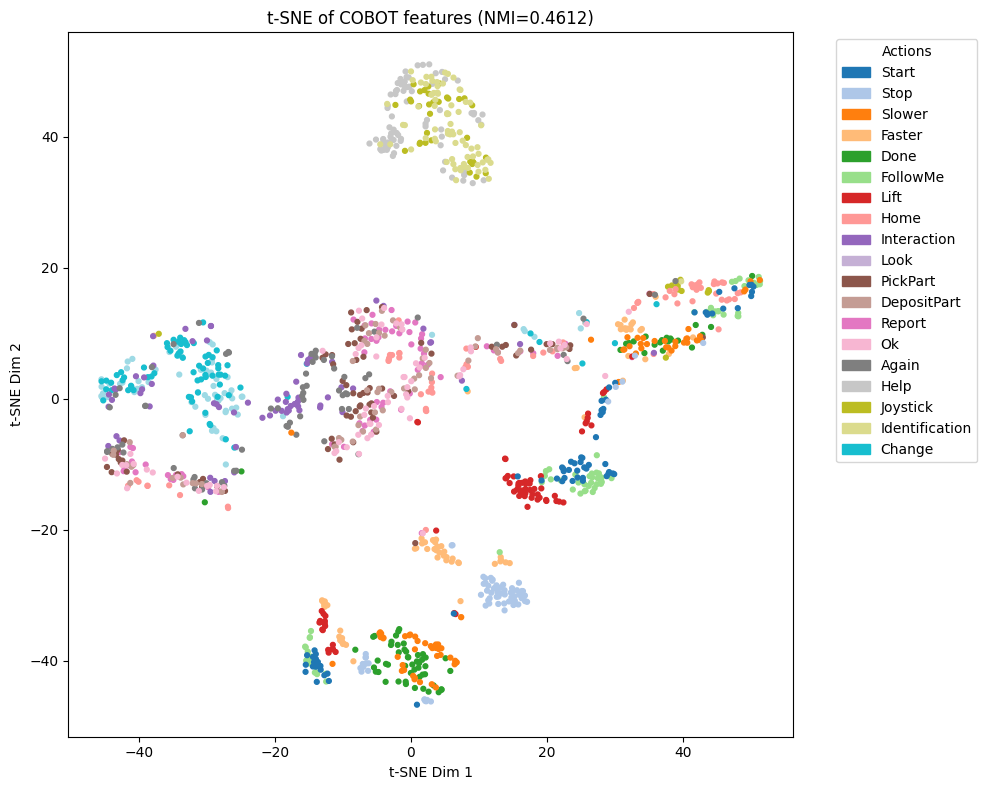

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Action names (the same order như labels_val)
action_names = [
    'Start', 'Stop', 'Slower', 'Faster', 'Done', 'FollowMe', 
    'Lift', 'Home', 'Interaction', 'Look', 'PickPart', 'DepositPart', 
    'Report', 'Ok', 'Again', 'Help', 'Joystick', 'Identification', 'Change'
]

plt.figure(figsize=(10,8))

# Scatter plot
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels_val, cmap='tab20', s=12)

# Create legend manually
handles = []
for i, name in enumerate(action_names):
    handles.append(mpatches.Patch(color=plt.cm.tab20(i/19), label=name))
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Actions")

plt.title(f"t-SNE of COBOT features (NMI={nmi_score:.4f})")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()


In [12]:
import time
batch_size = 1
times = []

# Warm-up 
with torch.no_grad():
    for i in range(0, len(labels_val), batch_size):
        batch_data = data_val[i:i+batch_size]
        batch_tensor = torch.from_numpy(batch_data).float().to(device)
        batch_features = model(None, batch_tensor, stream='all') 
        if device == 'cuda':
            torch.cuda.synchronize()

# Timed loop
with torch.no_grad():
    for i in range(0, len(labels_val), batch_size):
        batch_data = data_val[i:i+batch_size]
        batch_tensor = torch.from_numpy(batch_data).float().to(device)
        start = time.time()
        batch_features = model(None, batch_tensor, stream='all') 
        if device == 'cuda':
            torch.cuda.synchronize()
        end = time.time()
        
        times.append(end - start)


avg_time_ms = np.mean(times) * 1000
print(f"Average inference time per sample: {avg_time_ms:.2f} ms")


Average inference time per sample: 66.39 ms


In [14]:
import torch
import time

model.eval()  # always do this for inference

# prepare input ONCE, not inside timing
batch_tensor = torch.from_numpy(data_val[0:1]).float().to(device)

# warm-up
with torch.no_grad():
    for _ in range(10):
        model(None, batch_tensor, stream='all')

if device == 'cuda':
    torch.cuda.synchronize()

# timing exactly 1 forward
with torch.no_grad():
    if device == 'cuda':
        torch.cuda.synchronize()

    start = time.perf_counter()
    model(None, batch_tensor, stream='all')

    if device == 'cuda':
        torch.cuda.synchronize()
    end = time.perf_counter()

elapsed_ms = (end - start) * 1000
print(f"Inference time (1 forward): {elapsed_ms:.4f} ms")


Inference time (1 forward): 75.4638 ms


In [59]:
model_path = r'D:\HaAnh\AimCLR-v2-main\trial4_fixconfig_512\pretext\epoch400_model.pt'

model_class = import_class('net.aimclr_v2_3views_2.AimCLR_v2_3views')
model_args = {
    'base_encoder': 'net.ddnet.DDNet_Original',
    'Temperature': 0.3,
    'pretrain': True,
    'momentum': 0.999,
    'queue_size': 2048,
    'mlp':True,
    'class_num': 19,
    'frame_l': 60,
    'joint_d': 3,
    'joint_n': 48,
    'filters': 16,
    'last_feture_dim': 512,
    'feat_d': 1128

}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_class(**model_args)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model = model.to(device)
model.eval()

AimCLR_v2_3views(
  (encoder_q): DDNet_Original(
    (jcd_conv1): Sequential(
      (0): c1D(
        (conv1): Conv1d(1128, 32, kernel_size=(1,), stride=(1,), bias=False)
        (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): spatialDropout1D(
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (jcd_conv2): Sequential(
      (0): c1D(
        (conv1): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): spatialDropout1D(
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (jcd_conv3): c1D(
      (conv1): Conv1d(16, 16, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (jcd_pool): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [60]:
import sys
sys.path.append(r'D:\HaAnh\AimCLR-v2-main\feeder')

In [61]:
from feeder import tools
class Feeder_triple(torch.utils.data.Dataset):
    """ Feeder for triple inputs """
    def __init__(self, data_path, label_path, shear_amplitude=0.5, temperal_padding_ratio=6, mmap=True, aug_method='12345', zero_z=False):
        self.data_path = data_path
        self.label_path = label_path
        self.aug_method = aug_method

        self.shear_amplitude = shear_amplitude
        self.temperal_padding_ratio = temperal_padding_ratio
        self.zero_z = zero_z

        self.load_data(mmap)

    def load_data(self, mmap):
        # load label
        with open(self.label_path, 'rb') as f:
            self.sample_name, self.label = pickle.load(f)

        # load data
        if mmap:
            self.data = np.load(self.data_path, mmap_mode='r')
        else:
            self.data = np.load(self.data_path)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        # get data
        data_numpy = np.array(self.data[index])
        label = self.label[index]

        # processing
        data1 = self._strong_aug(data_numpy)
        data2 = self._aug(data_numpy)
        data3 = self._aug(data_numpy)
        return [data1, data2, data3], label

    def _aug(self, data_numpy):
        if self.temperal_padding_ratio > 0:
            data_numpy = tools.temperal_crop(data_numpy, self.temperal_padding_ratio)

        if self.shear_amplitude > 0:
            data_numpy = tools.shear(data_numpy, self.shear_amplitude)
        
        # Optionally zero out Z channel to treat data as 2D (T, V, C)
        if getattr(self, 'zero_z', False):
            data_numpy[:,:,2] = 0
        
        return data_numpy

    def _strong_aug(self, data_numpy):
        if self.temperal_padding_ratio > 0:
            data_numpy = tools.temperal_crop(data_numpy, self.temperal_padding_ratio)
        if self.shear_amplitude > 0:
            data_numpy = tools.shear(data_numpy, self.shear_amplitude)
        if '1' in self.aug_method:
            data_numpy = tools.random_spatial_flip(data_numpy)
        if '2' in self.aug_method:
            data_numpy = tools.random_rotate(data_numpy, is_2d=getattr(self, 'zero_z', False))
        if '3' in self.aug_method:
            data_numpy = tools.gaus_noise(data_numpy)
        if '4' in self.aug_method:
            data_numpy = tools.gaus_filter(data_numpy)
        if '5' in self.aug_method:
            data_numpy = tools.axis_mask(data_numpy)
        if '6' in self.aug_method:
            data_numpy = tools.random_time_flip(data_numpy)
        if '7' in self.aug_method:
            data_numpy = tools.random_scale_2d(data_numpy)
        if '8' in self.aug_method:
            data_numpy = tools.random_translate_2d(data_numpy)
        if '9' in self.aug_method:
            data_numpy = tools.random_joint_dropout_2d(data_numpy)
        if '0' in self.aug_method:
            data_numpy = tools.random_hand_emphasis_2d(data_numpy)
        
        # Optionally zero out Z channel to treat data as 2D (T, V, C)
        if getattr(self, 'zero_z', False):
            data_numpy[:,:,2] = 0
        
        return data_numpy

In [66]:
# Khởi tạo dataset triple
dataset = Feeder_triple(data_path, label_path, shear_amplitude=0.2, temperal_padding_ratio=6, aug_method='1234',zero_z=True, mmap=True)

loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

features = []
with torch.no_grad():
    for (data_triple, _) in loader:
        data1 = data_triple[0].to(device)
        data2 = data_triple[1].to(device)
        data3 = data_triple[2].to(device)

        feat = model(data1, data2, data3, stream='all')
        features.append(feat.cpu())

features = torch.cat(features).numpy()
print(features.shape)


: 

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(torch.from_numpy(data_val).float())
loader = DataLoader(dataset, batch_size=32, shuffle=False)

features = []
with torch.no_grad():
    for (batch,) in loader:
        batch = batch.to(device)
        feat = model(None, batch, stream='all')
        features.append(feat.cpu())

features = torch.cat(features).numpy()
print(features.shape)
